# Sentiment Analysis and Modelling

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

from sklearn.preprocessing import LabelEncoder, scale, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, roc_curve, classification_report
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, f1_score
from sklearn.linear_model import LogisticRegression

from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import nltk
# nltk.download("punkt")
# nltk.download('stopwords')
# nltk.download('wordnet')
# nltk.download('maxent_ne_chunker')
# nltk.download('words')
# nltk.download("averaged_perceptron_tagger")

import warnings
warnings.filterwarnings('ignore')
sns.set_style("whitegrid")
plt.rcParams['figure.dpi'] = 100

* Dosya ilk once excelde acilir, 4 sutundan olusan bir tablo. data frame olarak okutulabilir.

In [2]:
df=pd.read_csv('train.tsv',sep='\t')
df.head()

,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
1,2,1,A series of escapades demonstrating the adage ...,2
2,3,1,A series,2
3,4,1,A,2
4,5,1,series,2


In [3]:
df.shape

(156060, 4)

In [4]:
df.isnull().sum()

PhraseId      0
SentenceId    0
Phrase        0
Sentiment     0
dtype: int64

In [5]:
df.Sentiment.unique()

array([1, 2, 3, 4, 0], dtype=int64)

In [6]:
df.drop(['PhraseId','SentenceId'],axis=1,inplace=True)

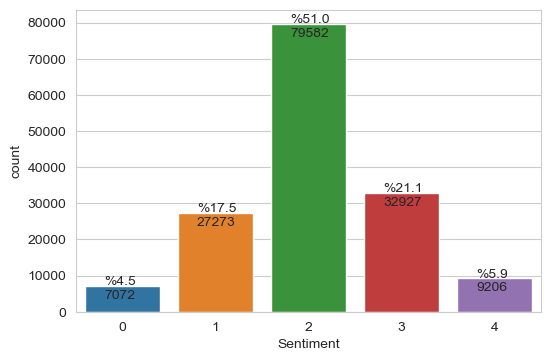

In [7]:
# fig,ax=plt.subplots(figsize=(10,6))

ax=sns.countplot(x='Sentiment', data=df)

for p in ax.patches:
        ax.annotate('%{:.1f}\n{:.0f}'.format(100*p.get_height()/len(df),p.get_height()), 
                    (p.get_x()+0.2, p.get_height()-3500))

* Dosyada sentiment Analiz yapilmis ve 0-4 arasi puanlama yapilmis. Bizim amacimiz 0 ve 1 leri Negatif, 3 ve 4 ler Pozitif, 2 leri so-so kabul ederek yeni siniflandirma yapmak. 2 olanlari drop etmek.

In [8]:
df.Sentiment=df.Sentiment.map({0:'Negative', 
                               1:'Negative', 
                               2:2, 
                               3:'Positive', 
                               4:'Positive'})

In [9]:
df.drop(df[ df['Sentiment'] ==2 ].index, axis=0,inplace=True)

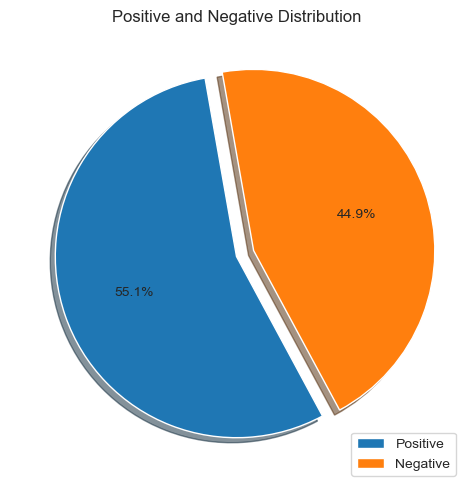

Positive    42133
Negative    34345
Name: Sentiment, dtype: int64

In [10]:
plt.figure(figsize=(6,6))

explode = [0,0.1]
plt.pie(df['Sentiment'].value_counts(),explode=explode,autopct='%1.1f%%',shadow=True,startangle=100)
plt.legend(labels=['Positive','Negative'])
plt.title('Positive and Negative Distribution')
plt.axis('off')
plt.show()

df.Sentiment.value_counts()

* Data can be considered as balanced

In [11]:
# # Alternative
# ax=sns.countplot(x='Sentiment', data=df)

# for p in ax.patches:
#         ax.annotate('%{:.1f}\n{:.0f}'.format(100*p.get_height()/len(df),p.get_height()), 
#                     (p.get_x()+0.3, p.get_height()-2000))

In [12]:
df.head()

,Phrase,Sentiment
0,A series of escapades demonstrating the adage ...,Negative
21,good for the goose,Positive
22,good,Positive
33,"the gander , some of which occasionally amuses...",Negative
46,amuses,Positive


* Feature adlarini daha anlasilir hale getirelim.

In [13]:
df.rename(columns={"Sentiment": "Labels", "Phrase": "Sentences"},inplace=True)

In [14]:
df.head()

,Sentences,Labels
0,A series of escapades demonstrating the adage ...,Negative
21,good for the goose,Positive
22,good,Positive
33,"the gander , some of which occasionally amuses...",Negative
46,amuses,Positive


* Tum data sette yalniz 1 defa gecen kelimeleri bulalim

In [15]:
valueDict=Counter(' '.join(df.Sentences).split())
rare_words=[k for k,v in valueDict.items() if v<2]
len(rare_words)

955

In [16]:
# # Alternative
# valueCounts=pd.Series(' '.join(df.Sentences).split()).value_counts()
# rare_words=valueCounts[valueCounts.values<2].index
# len(rare_words)

In [17]:
rare_words

['escapades',
 'Ismail',
 'Narratively',
 'mainland',
 '7',
 'preach',
 'exclusively',
 'Horton',
 'Decter',
 'Swinging',
 'hobby',
 'Tolstoy',
 'groupies',
 'Giannini',
 'near-future',
 'creature-feature',
 'chemicals',
 'Spalding',
 'Gray',
 'Cloaks',
 'Jolting',
 'copyof',
 'flame-like',
 'tentative',
 'puzzles',
 'masquerading',
 'Judith',
 'Zaza',
 'bedroom',
 'concentrate',
 'non-mystery',
 'resurrect',
 'longevity',
 'zip',
 'front-loaded',
 'shapely',
 '1990',
 'Nicely',
 'Broder',
 'Bear',
 'Delia',
 'Greta',
 'Paula',
 'Aussie',
 'channels',
 'not-quite-dead',
 'averse',
 '1972',
 'hinge',
 'Bart',
 'handguns',
 'BMWs',
 'seaside',
 'chateaus',
 'rollerball',
 'Claims',
 'directive',
 'costs',
 '50-million',
 'US',
 'biblical',
 'shrapnel',
 'shellshock',
 'Warren',
 'chop',
 'suey',
 'Jeopardy',
 'honks',
 'Pug',
 'roughage',
 'dominates',
 'subconscious',
 'fertility',
 'Goofy',
 'confounded',
 'bio-doc',
 'Falsehoods',
 'Chalk',
 'apes',
 'Justine',
 'smoothed',
 'Shankman

* rare_words listesini data frame den atalim.

In [18]:
f=lambda x: ' '.join([w if w not in rare_words else '' for w in x.split()])
df.Sentences=df.Sentences.apply(f)

In [19]:
df.head()

,Sentences,Labels
0,A series of demonstrating the adage that what...,Negative
21,good for the goose,Positive
22,good,Positive
33,"the gander , some of which occasionally amuses...",Negative
46,amuses,Positive


**Text Processing**
* Tokenization
* cleaning punctuations
* cleaning stopwords
* lemma

In [20]:
stop_words=stopwords.words('english')
lem=WordNetLemmatizer()

In [21]:
def cleaning(data):
    #1. Tokenize
    text_tokens=word_tokenize(data) 
    # Ozel isimlerle calismayacaksaniz, hepsini lowercase yapariz: word_tokenize(data.lower()) 
    
    #2. Remove Punc
    tokens_without_punc = [w for w in text_tokens if w.isalpha()]
    
    #3. Remove stopwords
    tokens_without_sw = [t for t in tokens_without_punc if t not in stop_words]
    
    #4. Lemmatize
    text_cleaned = [lem.lemmatize(t) for t in tokens_without_sw]
    
    #5. Joinning
    return ' '.join(text_cleaned)

In [22]:
df['Sentences']=df['Sentences'].apply(cleaning)
df.head()

,Sentences,Labels
0,A series demonstrating adage good goose also g...,Negative
21,good goose,Positive
22,good,Positive
33,gander occasionally amuses none amount much story,Negative
46,amuses,Positive


In [23]:
df.Sentences[0]

'A series demonstrating adage good goose also good gander occasionally amuses none amount much story'

* bazi bozuk veya romen rakamlari gibi ifadeler temizlenmediyse, rgex ile temizligi yapilir

**Feature Engineering**
* Count Vectors
* TF-IDF Vectors
* Word Embedding

**Splitting Data**

In [24]:
X=df['Sentences']
y=df["Labels"]

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,random_state=42)

In [25]:
X_train.head()

110319                                      mindless drivel
16891                                  tired going man gone
65038     notable largely overwhelming creepiness eagerness
8038      But though scratch surface least provides stro...
64644                                 There moment hilarity
Name: Sentences, dtype: object

In [26]:
y_train.head()

110319    Negative
16891     Negative
65038     Positive
8038      Positive
64644     Positive
Name: Labels, dtype: object

**LabelEncoder**

In [27]:
# from sklearn.preprocessing import LabelEncoder
encoder=LabelEncoder()
y_train=encoder.fit_transform(y_train)
y_test=encoder.transform(y_test)

**Count Vectorization**
* Apply to series not to df itself

In [28]:
# from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
vectorizer= CountVectorizer()
X_train_vectorized=vectorizer.fit_transform(X_train)
X_test_vectorized=vectorizer.transform(X_test)

> Her row icin len(vectorizer.get_feature_names()) kadar columns olacak, ilgili kelime icin 1, geri kalanlar icin 0 yazacak

In [29]:
vectorizer.get_feature_names()[:5]

['aaa', 'aaliyah', 'abagnale', 'abandon', 'abandoned']

In [30]:
X_train_vectorized.toarray()

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [31]:
pd.DataFrame(X_train_vectorized.toarray()).tail(5)

,0,1,2,3,4,5,6,7,8,9,...,12648,12649,12650,12651,12652,12653,12654,12655,12656,12657
53529,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
53530,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
53531,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
53532,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
53533,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [32]:
# pd.DataFrame(X_train_vectorized.toarray(),columns=vectorizer.get_feature_names())

In [33]:
# pd.set_option('display.max_columns',10000)

**TF-IDF**

In [34]:
tf_idf_vectorizer=TfidfVectorizer()
X_train_tf_idf = tf_idf_vectorizer.fit_transform(X_train)
X_test_tf_idf = tf_idf_vectorizer.transform(X_test)

In [35]:
pd.DataFrame(X_train_tf_idf.toarray()).head(5)

,0,1,2,3,4,5,6,7,8,9,...,12648,12649,12650,12651,12652,12653,12654,12655,12656,12657
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


> float deger uretti!

In [36]:
# pd.DataFrame(X_train_tf_idf.toarray(),columns=vectorizer.get_feature_names()).sum().sort_values(ascending=False)

In [37]:
# pd.DataFrame(X_train_tf_idf.toarray(),columns=vectorizer.get_feature_names()).max() #TF*IDF degerleri

* NLP calismalari genelde DataFrame uzerinde yapilir.
* Sentiment Analiz icin gerekli cleaning islemlerini yaptik 
* TFIDF weight is a statistical measure used to evaluate how important a word is to a document in a collection or corpus.
* TF-IDF are word frequency scores that try to highlight words that are more interesting
* kelimenin document ta cok gecmesi, corpus ta az gecmesi TF*IDF degerini artirir.

## Sentiment Classification

In [38]:
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.neighbors import KNeighborsClassifier

### 1-Logistic Regression

In [39]:
log_model=LogisticRegression()
log_model.fit(X_train_vectorized,y_train)
y_pred=log_model.predict(X_test_vectorized)

In [40]:
print('Confusion Matrix:',*confusion_matrix(y_test,y_pred), sep="\n")
print(classification_report(y_test, y_pred))

Confusion Matrix:
[8546 1693]
[ 1232 11473]
              precision    recall  f1-score   support

           0       0.87      0.83      0.85     10239
           1       0.87      0.90      0.89     12705

    accuracy                           0.87     22944
   macro avg       0.87      0.87      0.87     22944
weighted avg       0.87      0.87      0.87     22944



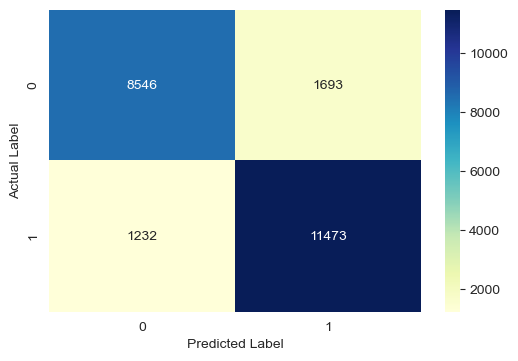

In [41]:
sns.heatmap(confusion_matrix(y_test,y_pred), annot=True, cmap="YlGnBu",fmt='d')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label');

In [42]:
# # Alternative
# from sklearn.metrics import plot_confusion_matrix
# plot_confusion_matrix(log_model,X_test_vectorized,y_test);

In [43]:
log_accuracy = log_model.score(X_test_vectorized,y_test)
log_f1_score = f1_score(y_test, y_pred, average='macro')
print('log_accuracy:',log_accuracy,
      '\nlog_f1_score:',log_f1_score)

log_accuracy: 0.8725156903765691 
log_f1_score: 0.8704066253205088


### 2-Random Forest

In [44]:
rf_model=RandomForestClassifier()
rf_model.fit(X_train_vectorized, y_train)
y_pred = rf_model.predict(X_test_vectorized)

In [45]:
print('Confusion Matrix:',*confusion_matrix(y_test,y_pred), sep="\n")
print(classification_report(y_test, y_pred))

Confusion Matrix:
[8672 1567]
[ 1047 11658]
              precision    recall  f1-score   support

           0       0.89      0.85      0.87     10239
           1       0.88      0.92      0.90     12705

    accuracy                           0.89     22944
   macro avg       0.89      0.88      0.88     22944
weighted avg       0.89      0.89      0.89     22944



In [46]:
rfc_accuracy = rf_model.score(X_test_vectorized,y_test)
rfc_f1_score = f1_score(y_test, y_pred, average='macro')
print('rfc_accuracy:',rfc_accuracy,
      '\nrfc_f1_score:',rfc_f1_score)

rfc_accuracy: 0.8860704323570432 
rfc_f1_score: 0.8841075398328777


### 3-XGBOOST

In [47]:
xgb_model = XGBClassifier()
xgb_model.fit(X_train_vectorized, y_train)

y_pred = xgb_model.predict(X_test_vectorized)

In [48]:
print('Confusion Matrix:',*confusion_matrix(y_test,y_pred), sep="\n")
print(classification_report(y_test, y_pred))

Confusion Matrix:
[4917 5322]
[  771 11934]
              precision    recall  f1-score   support

           0       0.86      0.48      0.62     10239
           1       0.69      0.94      0.80     12705

    accuracy                           0.73     22944
   macro avg       0.78      0.71      0.71     22944
weighted avg       0.77      0.73      0.72     22944



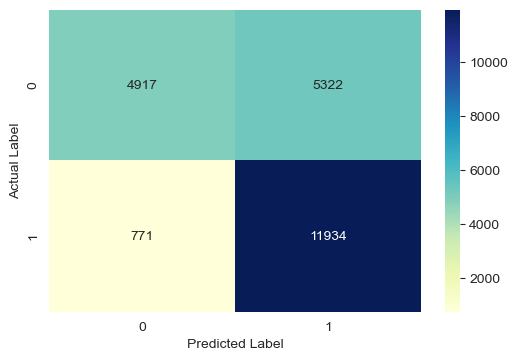

In [49]:
sns.heatmap(confusion_matrix(y_test,y_pred), annot=True, cmap="YlGnBu",fmt='d')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label');

**Tunning XGBOOST**

In [50]:
xgb = XGBClassifier()

In [51]:
xgb_params = {"n_estimators": [50, 100, 300,500],
             "subsample":[0.5,0.8,1],
             "max_depth":[3,5,7],
             "learning_rate":[0.1,0.01,0.3]}

In [52]:
# xgb_grid= RandomizedSearchCV(xgb, xgb_params, cv = 5,
#                              n_iter=10,
#                             n_jobs = -1, verbose = 2,scoring='f1').fit(X_train_vectorized, y_train)

In [53]:
# xgb_grid.best_params_

In [54]:
xgb_tuned = XGBClassifier(learning_rate= 1, 
                                max_depth= 100, 
                                n_estimators= 1000,
                                subsample= 1).fit(X_train_vectorized, y_train)

In [55]:
y_pred = xgb_tuned.predict(X_test_vectorized)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.84      0.89      0.86     10239
           1       0.91      0.86      0.88     12705

    accuracy                           0.87     22944
   macro avg       0.87      0.87      0.87     22944
weighted avg       0.87      0.87      0.87     22944



In [56]:
xgb_accuracy = accuracy_score(y_test, y_pred)
xgb_f1_score = f1_score(y_test, y_pred, average='macro')
print('xgb_accuracy:',xgb_accuracy,
      '\nxgb_f1_score:',xgb_f1_score)

xgb_accuracy: 0.8726464435146444 
xgb_f1_score: 0.8718418142190507


### 4-Naive Bayes Cassifier
* dokümanların sınıflandırılmasında yaygın olarak kullanılan bir sınıflandırıcıdır.

In [57]:
from sklearn.naive_bayes import MultinomialNB
naive_bayes= MultinomialNB()
naive_bayes.fit(X_train_vectorized,y_train)
y_pred=naive_bayes.predict(X_test_vectorized)

In [58]:
print('Confusion Matrix:',*confusion_matrix(y_test,y_pred), sep="\n")
print(classification_report(y_test, y_pred))

Confusion Matrix:
[8402 1837]
[ 1538 11167]
              precision    recall  f1-score   support

           0       0.85      0.82      0.83     10239
           1       0.86      0.88      0.87     12705

    accuracy                           0.85     22944
   macro avg       0.85      0.85      0.85     22944
weighted avg       0.85      0.85      0.85     22944



In [59]:
nb_accuracy = naive_bayes.score(X_test_vectorized,y_test)
nb_f1_score = f1_score(y_test, y_pred, average='macro')
print('nb_accuracy:',nb_accuracy,
      '\nnb_f1_score:',nb_f1_score)

nb_accuracy: 0.852902719665272 
nb_f1_score: 0.8507349651981215


# ``Accuracy & F1 Score Comparison``

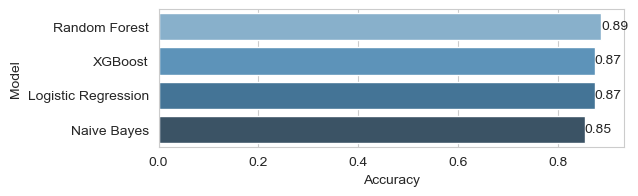

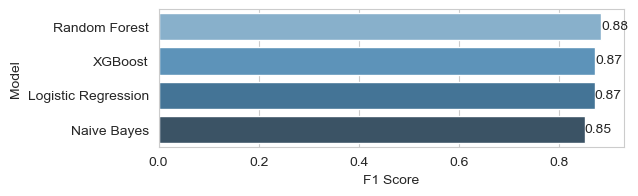

In [60]:
compare = pd.DataFrame({"Model": ["Random Forest", "XGBoost","Logistic Regression",'Naive Bayes'],
                        "Accuracy": [rfc_accuracy, xgb_accuracy, log_accuracy, nb_accuracy],
                        "F1 Score": [rfc_f1_score, xgb_f1_score, log_f1_score, nb_f1_score]})

def labels(ax):
    for p in ax.patches:
        width = p.get_width()    # get bar length
        ax.text(width,       # set the text at 1 unit right of the bar
                p.get_y() + p.get_height() / 2, # get Y coordinate + X coordinate / 2
                '{:1.2f}'.format(width), # set variable to display, 2 decimals
                ha = 'left',   # horizontal alignment
                va = 'center')  # vertical alignment
    
plt.subplot(211)
compare = compare.sort_values(by="Accuracy", ascending=False)
ax=sns.barplot(x="Accuracy", y="Model", data=compare, palette="Blues_d")
labels(ax)
plt.show()

plt.subplot(212)
compare = compare.sort_values(by="F1 Score", ascending=False)
ax=sns.barplot(x="F1 Score", y="Model", data=compare, palette="Blues_d")
labels(ax)
plt.show()